In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# "sigmoid cross entropy with logits" in lab material
from torch.nn.functional import binary_cross_entropy_with_logits as bincre_wlogits

import torchvision
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available()
                      else "cpu")
torch.manual_seed(1)


In [109]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

In [110]:
# Random sample
def sample_Z(m, n):
    return torch.randn(m, n)

# Re-implement function used in resources 
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / (in_dim / 2.)**0.5  # Using standard Python sqrt calculation
    return torch.randn(*size) * xavier_stddev

In [111]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.W1 = nn.Parameter(xavier_init([784, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 1]))
        self.b2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = torch.relu(x @ self.W1 + self.b1)
        logits = x @ self.W2 + self.b2
        prob = torch.sigmoid(logits)
        return prob, logits


class Generator(nn.Module):
    def __init__(self, zdim):
        super(Generator, self).__init__()
        self.W1 = nn.Parameter(xavier_init([zdim, 128]))
        self.b1 = nn.Parameter(torch.zeros(128))
        self.W2 = nn.Parameter(xavier_init([128, 784]))
        self.b2 = nn.Parameter(torch.zeros(784))

    def forward(self, z):
        z2 = torch.relu(z @ self.W1 + self.b1)
        log_prob = z2 @ self.W2 + self.b2
        prob = torch.sigmoid(log_prob)
        return prob

In [120]:
m = 50
zdim = 100

def train(iterations, loss_criterion="", no_printouts=4, no_samples=5):
    generator = Generator(zdim=zdim)
    discriminator = Discriminator()
    D_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.001)
    G_optimizer = torch.optim.Adam(params=generator.parameters(), lr=0.001)
    train_loader = DataLoader(train_set, batch_size=m, shuffle=True)

    d_history = []
    g_history = []
    torch.autograd.set_detect_anomaly(True) # for .backward tracing debugging
    assert (iterations/no_printouts) % 2 == 0, "iterations/no_printouts has to be even"

    print(f"m: {m}, zdim: {zdim}")
    if loss_criterion == "logistic":
        print("Running with logistic loss")
    
    for it in range(iterations):
        
        # Update discriminator
        # Note: due to training limitations, always run at k=1
        (batch_images, batch_label)  = next(iter(train_loader))
        batch_images = batch_images.view(batch_images.size(0), -1)  # Flatten the image tensor if needed
        Z = sample_Z(m, zdim)  # Sample noise

        D_optimizer.zero_grad()
        x = generator(Z)
        D_real, D_logit_real = discriminator(batch_images)
        D_fake, D_logit_fake = discriminator(x)    

        if loss_criterion == "logistic":
            D_loss_real = torch.mean(bincre_wlogits(D_logit_real, torch.ones_like(D_real)))
            D_loss_fake = torch.mean(bincre_wlogits(D_logit_fake, torch.ones_like(D_fake)))
            D_loss = D_loss_real + D_loss_fake
        else:
            D_loss = -torch.mean(torch.log(D_real) + torch.log(torch.ones(D_fake.shape) - D_fake))

        D_loss.backward(retain_graph=True)
        D_optimizer.step()
            

        # Update generator
        G_Z = sample_Z(m, zdim)  # Sample noise
        G_optimizer.zero_grad()
        G_img_fake = generator(G_Z)
        G_fake, G_logit_fake = discriminator(G_img_fake)
        
        if loss_criterion == "logistic":
            G_loss = torch.mean(bincre_wlogits(G_logit_fake, torch.ones_like(G_fake)))
        else:
            G_loss = -torch.mean(torch.log(1 - G_fake))

        G_loss.backward(retain_graph=True)
        G_optimizer.step()

        
        # Printouts + history
        d_history.append(D_loss.item())
        g_history.append(G_loss.item())
        if it % (iterations/no_printouts) == 0:
            print(f"Iteration {it}: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
            r = m if m < no_samples else no_samples
            fig, axes = plt.subplots(1, r, figsize=(r, 1), sharex=True, sharey=True)
            for ri in range(r):
                G_img = G_img_fake[ri].detach()
                G_img = torch.reshape(G_img, [28,28])
                axes[ri].imshow(G_img, cmap='gray')
                axes[ri].axis('off')
            plt.show()

    print(f"Final: D_loss {D_loss.item()}, G_loss {G_loss.item()}")
    plt.plot(d_history, label="Discriminator loss")
    plt.plot(g_history, label="Generator loss")
    plt.legend()
    plt.show()

    return discriminator, generator

m: 50, zdim: 100
Iteration 0: D_loss 1.3205666542053223, G_loss 0.07085705548524857


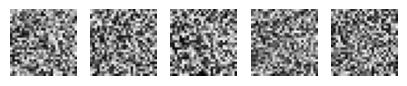

Iteration 2500: D_loss 8.392383392674674e-07, G_loss 5.364417887676609e-08


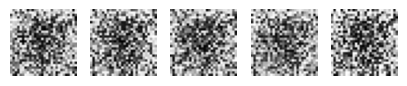

Iteration 5000: D_loss 4.0412282942270394e-07, G_loss -0.0


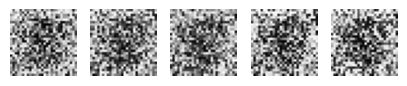

Iteration 7500: D_loss 2.3841861818141297e-09, G_loss 1.19209286886246e-09


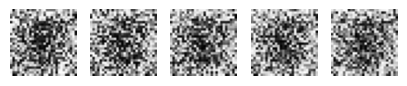

Final: D_loss 9.536745615434938e-09, G_loss -0.0


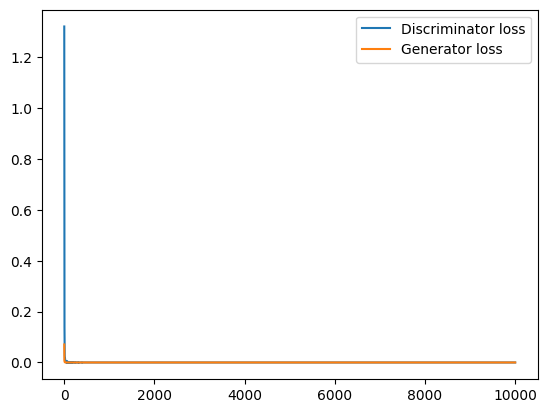

In [121]:
# 2.1: Train with std loss
D11, G11 = train(iterations=10_000)
#D12, G12 = train(iterations=100_000) #Not sure if needed (instructions are vague)

In [ ]:
# 2.2: Train with logistic loss
D21, G21 = train(iterations=20_000, loss_criterion="logistic")
D22, G22 = train(iterations=100_000, loss_criterion="logistic")

In [ ]:
# 2.3

In [ ]:
# 2.4

In [ ]:
# 2.5 is implemented in a separate folder (too long to fit here)